In [1]:
import numpy as np
import re as re
import matplotlib.pyplot as plt
from numpy.linalg import solve,norm,inv
from random import uniform
from sympy import symbols,diff,sympify,lambdify,default_sort_key
from sympy.parsing.sympy_parser import parse_expr

In [43]:
########################################################
#Funções de suporte
########################################################

#Dado uma determinada lista de funções f(x) = b em formato string, retorna f(x) - b
def set_to_root(functions_strings):
    return [re.sub("=","-",function)for function in functions_strings]
    
def parse_string_to_sympy(functions_strings):
    return [parse_expr(function,evaluate=False)for function in functions_strings]
    
#Retorna a função lambda da expressão sympy. A função irá receber todas as variáveis livres da expressão em forma
#vetorial
#expr - expressão no formato sympy
def vector_lambdify(expr):
    return lambdify(np.array([sorted(list(expr.free_symbols), key = lambda x:x.sort_key())]),expr)

#Retorna um array contendo funções anonimas equivalentes cada função da lista de entrada.
#functions - lista de funções no formato sympy
def parse_system_to_lambda(functions):
    number_variables = len(functions[0].free_symbols)
    return ([vector_lambdify(function)
            for function in functions],number_variables) 


#Calcula as derivadas de f em relação à cada elemento de x0.
#O procedimento calcula uma matriz quadrada(offset_matrix) contendo N vetoes ,sendo N o número de elementos em x0.
#Seja i um índice em x0 e xK um vetor em offset_matrix, xK[i] = h; xK[j] = 0, j =/= i;
#f  - função de 1 ou várias variáveis
#x0 -vetor de pontos
#return - lista contendo o resultado da derivação em relação à cada elemento
def gradient_vec(f,x0):
    h = 1e-10
    offset_matrix = np.array([[h if (i==j) else 0 for i in range(x0.size)] for j in range(x0.size)])
    return [(f(x0+offset)- f(x0))/h for offset in offset_matrix]

#Retorna a matriz jacobiana da função de entrada
def Jacobian(f_vec,x0):
    return [gradient_vec(fi,x0) for fi in f_vec]

#Dado uma função vetorial f_vec(.)(um sistema de funções fi aplicados em x1,x2...xn = x) retorna f_vec(x)
def eval_system(f_vec,x):
    return np.array([f(x) for f in f_vec])

########################################################
#Newton e Broyden
########################################################

#Resolve um sistema de equações não-lineares pelo método de newton
#f_list - lista de funções anonimas f(x) correspondente ao sistema sendo resolvido(f(x) = 0)
#N - numero de variáveis livres
#tol - tolerância de valor para f(x). Critério de parada e convergência: ||dX||/||X||
#return - tupla contendo um vetor com o valor encontrado para os parametrôs e uma variável booleana cotendo
#a informação de convergência
def solve_by_newton(f_list,N,tol):
    maxIterNum = 100000
    max_divergence = 10e+50
    
    x = np.array([1 if (i % 2 == 0) else 0 for i in range(N)])
    convergence = False
    count = 0
    
    #print('Iteration             X              f(X)')
    while(count < maxIterNum):
        fx = eval_system(f_list, x)

        dx = solve(Jacobian(f_list,x),(-1)*fx)
        x = x + dx
    #    print(count, "    ", x, eval_system(f_list,x))
        if (norm(dx)/norm(x) < tol): 
            convergence = True
            break
        count +=1
    return (x, convergence)

#Resolve um sistema de equações não-lineares pelo método de broyden
#f_list - 
#N - numero de variáveis livres
#tol - tolerância de valor para f(x). Critério de parada e convergência: ||dX||/||X||
#return - tupla contendo um vetor com o valor encontrado para os parametrôs e uma variável booleana cotendo
#a informação de convergência
def solve_by_broyden(f_list,N,tol):
    maxIterNum = 10000
    max_divergence = 1e+50
    
    x = np.array([1 if (i % 2 == 0) else 0 for i in range(N)])
    J = Jacobian(f_list,x)
    convergence = False
    count = 0
    
    #print('Iteration             X              f(X)')
    while(count < maxIterNum):
        fx0 = eval_system(f_list,x)
        dx = solve(J,(-1)*fx0)
        x = x + dx
        fx1 = eval_system(f_list,x)
        J = J + (1/np.dot(dx,dx))*(np.outer(fx1,dx))
    #    print(count, "    ", x, eval_system(f_list,x))
        if (norm(dx)/norm(x) < tol): 
            convergence = True
            break
        count +=1
        
    return (x, convergence)

#Resolve um sistema não-linear pelo método de newton ou pelo método de broyden
#system - conjunto string contendo o sistema de equações
#method - string contendo o método a ser usado
#return - valor da solução do sistema(em caso de método inválido, retorna [0])
def solve_non_linear(system, method):
    system_pre_processed = set_to_root(system)
    system_sympy = parse_string_to_sympy(system_pre_processed)
    (f_vec,N) = parse_system_to_lambda(system_sympy)
    if (method.lower() == "newton"):
        return solve_by_newton(f_vec,N,10e-04)
    if (method.lower() == "broyden"):
        return solve_by_broyden(f_vec,N,10e-04)
    print("Método invalido de resolução")
    return np.zeros(1)

########################################################
#Regressão nao-linear
########################################################

#Implementa o método de newton para achar os parâmetros da função sendo ajustada
#fit_function_list - lista de funçoes anonimas parcialmente preenchidas com os devidos valores de dados 
#N - número de parâmetros a serem ajustados
#tol - tolerância de valor para f(x). Critério de parada e convergência: ||dX||/||X||
#return - tupla contendo um vetor com o valor encontrado para os parametrôs e uma variável booleana cotendo
#a informação de convergência
def fit_by_newton(fit_function_list, N,tol):
    maxIterNum = 1000
    max_divergence = 1e+10
    
    B = np.array([i for i in range(N)])
    convergence = False
    count = 0
    while(count < maxIterNum):
        JB = Jacobian(fit_function_list,B)
        trJB = (np.array(JB)).transpose()
        fB = eval_system(fit_function_list,B)
        dB = np.matmul(np.matmul(((-1)*inv(np.matmul(trJB,JB))),trJB),fB)
        if(norm(dB)/norm(B) < tol):
            convergence = True
            break
        B = B + dB
        count +=1
    return B
    

#Aplica regressão não linear da função (fit) em um conjunto de dados(data+y)
def nonlinear_regression(fit,data,y):
    fit_y = [(fit + ' + ' + repr(y[i])) if (y[i] < 0) 
             else (fit + ' - ' + repr(y[i]))  for i in range(y.size)]
    fit_sympy = parse_string_to_sympy(fit_y)
    (fit_lambda, number_of_symbols) = parse_system_to_lambda(fit_sympy)
    number_of_parameters = number_of_symbols - 1
    #Gera nova lista da função fit que recebe apenas os valores dos parâmetros e mantém fixo pontos
    #de dados. A uma função no indice i da lista corresponde à função fit aplicada ao dado em data[i].
    fit_parameters = [(lambda x,element=element,i=i: fit_lambda[i](np.append(x,element)))
                      for i,element in zip(range(y.size),data)]
    return fit_by_newton(fit_parameters,number_of_parameters,10e-04)

#Plota a função fit(B) e y x dados 
def plot_fit(fit, B,data,y):
    fit_string = set_to_root([fit])
    fit_sympy = parse_string_to_sympy(fit_string)
    (fit_lambda, number_of_symbols) = parse_system_to_lambda(fit_sympy)
    fit_plot = lambda x: fit_lambda[0](np.append(B,x))
    fit_plot_v = np.vectorize(fit_plot)
    x = np.arange(0.5, 5, 0.1)
    plt.plot(x,fit_plot_v(x))
    plt.scatter(data, y)
    
    plt.show()

In [44]:
#3)
system = np.array(["16*x1**4 + 16*x2**4 + x3**4 = 16",
                  "x1**2 + x2**2 + x3**2 = 3",
                   "x1**3 - x2 + x3 = 1"])

print("Newton: ", solve_non_linear(system,"newton")[0])
print("Broyden: ", solve_non_linear(system,"broyden")[0])

Newton:  [ 0.7904098   0.8068882   1.31308185]
Broyden:  [ 0.79032879  0.80686016  1.31313331]


In [46]:
#4) a)
system = np.array(["2*x1 + x2**2 + 6*x3**2  = 1",
                  "8*x1**3 + 6*x1*x2**2 + 36*x1*x2*x3 + 108*x1*x3**2 = 0",
                   "60*x1**4 + 60*(x1**2)*(x2**2) + 576*(x1**2)*x2*x3 +\
                   2232*(x1**2)*x3**2 + 252*(x3**2)*x2**2 + 1296*(x3**3)*x2\
                   + 3348*x3**3 + 24*(x2**3)*x3 + 3*x2 = 3"])

print("Newton: ", solve_non_linear(system,"newton")[0])
print("Broyden: ", solve_non_linear(system,"broyden")[0])

Newton:  [  2.63825805e-11   1.00000001e+00   4.37386757e-08]
Broyden:  [ 0.0018769   0.99565311 -0.02603574]


In [45]:
#4) b)
system = np.array(["2*x1 + x2**2 + 6*x3**2  = 1",
                  "8*x1**3 + 6*x1*x2**2 + 36*x1*x2*x3 + 108*x1*x3**2 = 0.75",
                   "60*x1**4 + 60*(x1**2)*(x2**2) + 576*(x1**2)*x2*x3 +\
                   2232*(x1**2)*x3**2 + 252*(x3**2)*x2**2 + 1296*(x3**3)*x2\
                   + 3348*x3**3 + 24*(x2**3)*x3 + 3*x2 = 6.5"])

print("Newton: ", solve_non_linear(system,"newton")[0])
print("Broyden: ", solve_non_linear(system,"broyden")[0])

Newton:  [ 0.10575786  0.8744296   0.06305705]
Broyden:  [ 0.10530335  0.87515616  0.06271792]


In [47]:
#4) c)
system = np.array(["2*x1 + x2**2 + 6*x3**2  = 1",
                  "8*x1**3 + 6*x1*x2**2 + 36*x1*x2*x3 + 108*x1*x3**2 = 0",
                   "60*x1**4 + 60*(x1**2)*(x2**2) + 576*(x1**2)*x2*x3 +\
                   2232*(x1**2)*x3**2 + 252*(x3**2)*x2**2 + 1296*(x3**3)*x2\
                   + 3348*x3**3 + 24*(x2**3)*x3 + 3*x2 = 11.667"])

print("Newton: ", solve_non_linear(system,"newton")[0])
print("Broyden: ", solve_non_linear(system,"broyden")[0])

Newton:  [  3.39448258e-11   9.70801329e-01   9.79326142e-02]
Broyden:  [  5.82082258e-04   9.69009211e-01   1.00181037e-01]


In [48]:
#5)
y = np.array([1,2,9])
data = np.array([1,2,3])
f = "b0 + b1*x**b2"
B1 = nonlinear_regression(f,data,y)


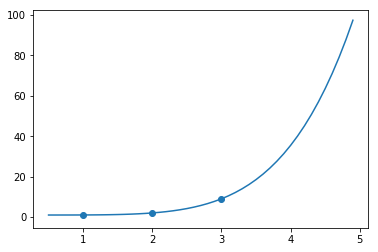

In [49]:
plot_fit(f,B1,data,y)